# Descrição do Modelo

Este modelo utiliza **XGBoost** para prever a qualificação de clientes na aquisição de imóveis, gerando scores de 0 a 100. O modelo alcançou **RMSE de 0.44** e **R² superior a 0.95**.

## Problema da versão anterior

O modelo apresentava **overfitting em profissões específicas**, por exemplo `profissao_empresario` representando 11.2% da importância total, indicando memorização de padrões ao invés de generalização adequada (overfitting).

## Técnicas Aplicadas

**1. Pré-processamento**
- Limpeza de dados (lowercase, strip de espaços)
- Agrupamento de categorias raras (< 2% dos dados) em "outros"

**2. Target Encoding**
Aplicado exclusivamente na feature `profissao`, convertendo 30 categorias em uma única coluna numérica baseada na média do target. Isso reduziu a importância de profissões de 25.7% para 5.1%, eliminando overfitting.

**3. One-Hot Encoding**
Utilizado nas demais features categóricas (`gênero`, `estado_civil`, `cidade`, `urgência`, `forma_pagamento`, `objetivo`) com `drop_first=True` para evitar multicolinearidade.

**4. Feature Engineering**
Criação de features derivadas para capturar relações complexas:
- `poder_compra = score_credito × renda_mensal / 1000`: tornou-se a feature mais importante (36.6%)
- `razao_valor_renda = valor_imovel / renda_mensal`: mede affordability

**5. Normalização**
StandardScaler aplicado em features numéricas (`renda_mensal`, `score_credito`, `idade`, `valor_imovel`) após o split treino-teste para evitar `data leakage`.

**6. Cross-Validation (5-folds)**
Validação cruzada com re-encoding em cada fold garantiu avaliação robusta. CV RMSE (0.46) próximo ao teste (0.44) confirma boa generalização.

**7. Regularização XGBoost**
Hiperparâmetros ajustados (`max_depth=4`, `learning_rate=0.02`, `min_child_weight=10`, `reg_lambda=3.0`) para balancear performance e prevenção de overfitting.

## Resultados

O modelo final apresentou **melhoria de 53%** no RMSE comparado à versão inicial que não possuia feature engineering e aplicava label encoding ao invés de target encoding . Features numéricas e engenhadas dominam 62.8% da importância, garantindo predições baseadas em capacidade financeira real.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import  RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
caminho = '/content/clientes_imoveis.csv'
df = pd.read_csv(caminho)

In [3]:
df.head()

,id,idade,genero,estado_civil,profissao,renda_mensal,cidade_estado_residencia,composicao_familiar,score_credito,cidade_imovel,valor_imovel,objetivo,forma_pagamento,urgencia,label
0,1,40,Feminino,Casado(a),Gerente de Projetos,18613,Aracaju/SE,5,445,Santo Andre/SP,400000,Morar,À vista,Até 3 meses,54
1,2,48,Outro,Casado(a),Gerente de Projetos,18542,Itajai/SC,4,785,Itajai/SC,622000,Morar,À vista,Mais de um ano,58
2,3,49,Masculino,Casado(a),Arquiteto,11229,Rio de Janeiro/RJ,2,528,Londrina/PR,296000,Investir,Financiamento,Até 3 meses,47
3,4,60,Feminino,Casado(a),Psicologo,10232,Araraquara/SP,2,557,Araraquara/SP,204000,Morar,Financiamento,Até 3 meses,49
4,5,58,Outro,Casado(a),Autonomo,10644,Guarulhos/SP,2,425,Guarulhos/SP,193000,Morar,Financiamento,Mais de um ano,40


In [4]:
df.columns

Index(['id', 'idade', 'genero', 'estado_civil', 'profissao', 'renda_mensal',
       'cidade_estado_residencia', 'composicao_familiar', 'score_credito',
       'cidade_imovel', 'valor_imovel', 'objetivo', 'forma_pagamento',
       'urgencia', 'label'],
      dtype='object')

In [5]:

X = df.drop('label', axis=1)
y = df['label'].values

In [6]:
from sklearn.preprocessing import TargetEncoder
#data preparation
colunas_numericas = ['renda_mensal', 'score_credito', 'idade', 'valor_imovel']
colunas_nominais = ['profissao', 'genero', 'estado_civil', 'cidade_imovel',
                    'objetivo', 'cidade_estado_residencia', 'urgencia', 'forma_pagamento']

X_processed = X.copy()

for col in colunas_nominais:
    X_processed[col] = X_processed[col].str.lower().str.strip()

# Contar profissões antes do agrupamento (para comparação)
num_profissoes_original = X_processed['profissao'].nunique()

# Agrupar categorias raras exceto profissão
valor_min = 0.02
colunas_para_agrupar = ['cidade_imovel', 'cidade_estado_residencia', 'objetivo']

for col in colunas_para_agrupar:
    freq_col = X_processed[col].value_counts(normalize=True)
    raras_col = freq_col[freq_col < valor_min].index
    X_processed[col] = X_processed[col].apply(
        lambda x: 'outros' if x in raras_col else x
    )
#Feature engineering
X_processed['razao_valor_renda'] = X_processed['valor_imovel'] / (X_processed['renda_mensal'])
X_processed['poder_compra'] = X_processed['score_credito'] * X_processed['renda_mensal'] / 1000

# Adicionando as colunas numéricas:
colunas_numericas = ['renda_mensal','razao_valor_renda', 'score_credito', 'idade', 'valor_imovel', 'poder_compra']
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=42
)

# target encoding para profissão
target_encoder = TargetEncoder(smooth='auto', target_type='continuous')

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# aplicando target encoding apenas em profissão
X_train_copy['profissao_encoded'] = target_encoder.fit_transform(
    X_train[['profissao']], y_train
)
X_test_copy['profissao_encoded'] = target_encoder.transform(
    X_test[['profissao']]
)

# removendo profissão original das colunas nominais
colunas_nominais_sem_profissao = [col for col in colunas_nominais if col != 'profissao']

# one hot encoding nas outras categorias
X_train_encoded = pd.get_dummies(
    X_train_copy.drop('profissao', axis=1),
    columns=colunas_nominais_sem_profissao,
    drop_first=True
)
X_test_encoded = pd.get_dummies(
    X_test_copy.drop('profissao', axis=1),
    columns=colunas_nominais_sem_profissao,
    drop_first=True
)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_encoded[colunas_numericas] = scaler.fit_transform(X_train_encoded[colunas_numericas])
X_test_encoded[colunas_numericas] = scaler.transform(X_test_encoded[colunas_numericas])

print(f"Profissões originais: {num_profissoes_original}")
print(f"Agora 'profissao' = 1 coluna encoded (ao invés de {num_profissoes_original - 1} com one-hot)")
print(f"Total de features: {X_train_encoded.shape[1]}")


Profissões originais: 30
Agora 'profissao' = 1 coluna encoded (ao invés de 29 com one-hot)
Total de features: 74


In [7]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'learning_rate': 0.02,
    'n_estimators': 1500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'min_child_weight': 10,
    'gamma': 0.3,
    'reg_alpha': 0.5,
    'reg_lambda': 3.0,
    'random_state': 42,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 100
}

modelo = xgb.XGBRegressor(**params)

eval_set = [(X_train_encoded, y_train), (X_test_encoded, y_test)]
modelo.fit(
    X_train_encoded, y_train,
    eval_set=eval_set,
    verbose=60
)

[0]	validation_0-rmse:11.34398	validation_1-rmse:11.29692
[60]	validation_0-rmse:4.51968	validation_1-rmse:4.55043
[120]	validation_0-rmse:2.33712	validation_1-rmse:2.42484
[180]	validation_0-rmse:1.45413	validation_1-rmse:1.57044
[240]	validation_0-rmse:1.01063	validation_1-rmse:1.13190
[300]	validation_0-rmse:0.76771	validation_1-rmse:0.88898
[360]	validation_0-rmse:0.63753	validation_1-rmse:0.75496
[420]	validation_0-rmse:0.55436	validation_1-rmse:0.66737
[480]	validation_0-rmse:0.50502	validation_1-rmse:0.61405
[540]	validation_0-rmse:0.47196	validation_1-rmse:0.57715
[600]	validation_0-rmse:0.44807	validation_1-rmse:0.55024
[660]	validation_0-rmse:0.43009	validation_1-rmse:0.52998
[720]	validation_0-rmse:0.41694	validation_1-rmse:0.51524
[780]	validation_0-rmse:0.40653	validation_1-rmse:0.50333
[840]	validation_0-rmse:0.39724	validation_1-rmse:0.49324
[900]	validation_0-rmse:0.38925	validation_1-rmse:0.48486
[960]	validation_0-rmse:0.38213	validation_1-rmse:0.47789
[1020]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, ...)

In [8]:
#CV com o target encoding
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
cv_rmse = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    # Split do fold
    X_fold_train = X_train.iloc[train_idx].copy()
    X_fold_val = X_train.iloc[val_idx].copy()
    y_fold_train = y_train[train_idx]
    y_fold_val = y_train[val_idx]

    # Target encoding no fold
    te_fold = TargetEncoder(smooth='auto', target_type='continuous')
    X_fold_train['profissao_encoded'] = te_fold.fit_transform(
        X_fold_train[['profissao']], y_fold_train
    )
    X_fold_val['profissao_encoded'] = te_fold.transform(
        X_fold_val[['profissao']]
    )

    # One-hot nas outras colunas
    X_fold_train_enc = pd.get_dummies(
        X_fold_train.drop('profissao', axis=1),
        columns=colunas_nominais_sem_profissao,
        drop_first=True
    )
    X_fold_val_enc = pd.get_dummies(
        X_fold_val.drop('profissao', axis=1),
        columns=colunas_nominais_sem_profissao,
        drop_first=True
    )

    # Alinhar colunas
    X_fold_val_enc = X_fold_val_enc.reindex(columns=X_fold_train_enc.columns, fill_value=0)

    # Scaling
    scaler_fold = StandardScaler()
    X_fold_train_enc[colunas_numericas] = scaler_fold.fit_transform(X_fold_train_enc[colunas_numericas])
    X_fold_val_enc[colunas_numericas] = scaler_fold.transform(X_fold_val_enc[colunas_numericas])

    # Treinar modelo
    modelo_cv = xgb.XGBRegressor(**params)
    modelo_cv.fit(
        X_fold_train_enc, y_fold_train,
        eval_set=[(X_fold_val_enc, y_fold_val)],
        verbose=0
    )

    y_val_pred = np.clip(modelo_cv.predict(X_fold_val_enc), 0, 100)
    mse_fold = mean_squared_error(y_fold_val, y_val_pred)
    rmse_fold = np.sqrt(mse_fold)

    cv_scores.append(mse_fold)
    cv_rmse.append(rmse_fold)
    print(f"Fold {fold}: MSE={mse_fold:.4f}, RMSE={rmse_fold:.4f}")

print(f"CV MSE Médio:  {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"CV RMSE Médio: {np.mean(cv_rmse):.4f} ± {np.std(cv_rmse):.4f}")

# Avaliação final no teste
y_test_pred = np.clip(modelo.predict(X_test_encoded), 0, 100)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print(f"COMPARAÇÃO FINAL:")
print(f"CV RMSE Médio:    {np.mean(cv_rmse):.4f} ± {np.std(cv_rmse):.4f}")
print(f"Teste RMSE:       {test_rmse:.4f}")
print(f"Diferença:        {abs(np.mean(cv_rmse) - test_rmse):.4f}")

Fold 1: MSE=0.2304, RMSE=0.4800
Fold 2: MSE=0.2180, RMSE=0.4669
Fold 3: MSE=0.2148, RMSE=0.4634
Fold 4: MSE=0.2136, RMSE=0.4621
Fold 5: MSE=0.1899, RMSE=0.4358
CV MSE Médio:  0.2133 ± 0.0131
CV RMSE Médio: 0.4617 ± 0.0144
COMPARAÇÃO FINAL:
CV RMSE Médio:    0.4617 ± 0.0144
Teste RMSE:       0.4444
Diferença:        0.0172


# Script para analisar as features (feito por IA)
esse script visa analisar a importância de cada feature

In [9]:
# ============================================
# ANÁLISE COMPLETA DAS FEATURES
# ============================================
importance_df = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': modelo.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("🔝 TOP 20 FEATURES MAIS IMPORTANTES (COM FEATURE ENGINEERING)")
print("="*60)
print(importance_df.head(20).to_string(index=False))

# Verificar se as novas features estão no top
print(f"\n{'='*60}")
print("🆕 RANKING DAS FEATURES CRIADAS:")
print("="*60)

features_criadas = ['razao_valor_renda', 'poder_compra']
for feat in features_criadas:
    if feat in importance_df['feature'].values:
        row = importance_df[importance_df['feature'] == feat].iloc[0]
        rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == feat].index[0]) + 1
        print(f"{feat:25s} | Importância: {row['importance']:.4f} ({row['importance']*100:.2f}%) | Rank: #{rank}")

# Comparar features numéricas originais
print(f"\n{'='*60}")
print("📊 FEATURES NUMÉRICAS ORIGINAIS:")
print("="*60)
for col in ['score_credito', 'valor_imovel', 'renda_mensal', 'idade']:
    if col in importance_df['feature'].values:
        row = importance_df[importance_df['feature'] == col].iloc[0]
        rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == col].index[0]) + 1
        print(f"{col:25s} | Importância: {row['importance']:.4f} ({row['importance']:.2f}%) | Rank: #{rank}")

# Profissão ainda equilibrada?
print(f"\n{'='*60}")
print("👔 PROFISSAO_ENCODED:")
print("="*60)
if 'profissao_encoded' in importance_df['feature'].values:
    row = importance_df[importance_df['feature'] == 'profissao_encoded'].iloc[0]
    rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == 'profissao_encoded'].index[0]) + 1
    print(f"Rank: #{rank} | Importância: {row['importance']:.4f} ({row['importance']*100:.2f}%)")


🔝 TOP 20 FEATURES MAIS IMPORTANTES (COM FEATURE ENGINEERING)
                               feature  importance
                          poder_compra    0.365735
                         score_credito    0.132540
                          valor_imovel    0.092546
                     urgencia_imediato    0.083797
               urgencia_mais de um ano    0.076521
                          renda_mensal    0.073917
               forma_pagamento_à vista    0.062059
                     profissao_encoded    0.050509
                  urgencia_até 3 meses    0.041770
                     razao_valor_renda    0.015204
              estado_civil_solteiro(a)    0.000414
                   composicao_familiar    0.000296
               cidade_imovel_manaus/am    0.000147
     cidade_estado_residencia_belem/pa    0.000129
  cidade_estado_residencia_curitiba/pr    0.000128
               cidade_imovel_santos/sp    0.000115
            cidade_imovel_fortaleza/ce    0.000108
            cidade_i

In [10]:

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# predições
y_train_pred = np.clip(modelo.predict(X_train_encoded), 0, 100)
y_test_pred = np.clip(modelo.predict(X_test_encoded), 0, 100)

# métricas treino
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# métricas teste
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(" MÉTRICAS COMPLETAS DO MODELO")
print(f"{'Métrica':<20} {'Treino':<15} {'Teste':<15} {'Diferença':<15}")
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f} {abs(train_r2-test_r2):<15.4f}")
print(f"{'RMSE':<20} {train_rmse:<15.4f} {test_rmse:<15.4f} {abs(train_rmse-test_rmse):<15.4f}")
print(f"{'MAE':<20} {train_mae:<15.4f} {test_mae:<15.4f} {abs(train_mae-test_mae):<15.4f}")


 MÉTRICAS COMPLETAS DO MODELO
Métrica              Treino          Teste           Diferença      
R² Score             0.9991          0.9985          0.0006         
RMSE                 0.3419          0.4444          0.1025         
MAE                  0.2744          0.3533          0.0788         


In [11]:
import matplotlib.pyplot as plt

#Gráficos do modelo

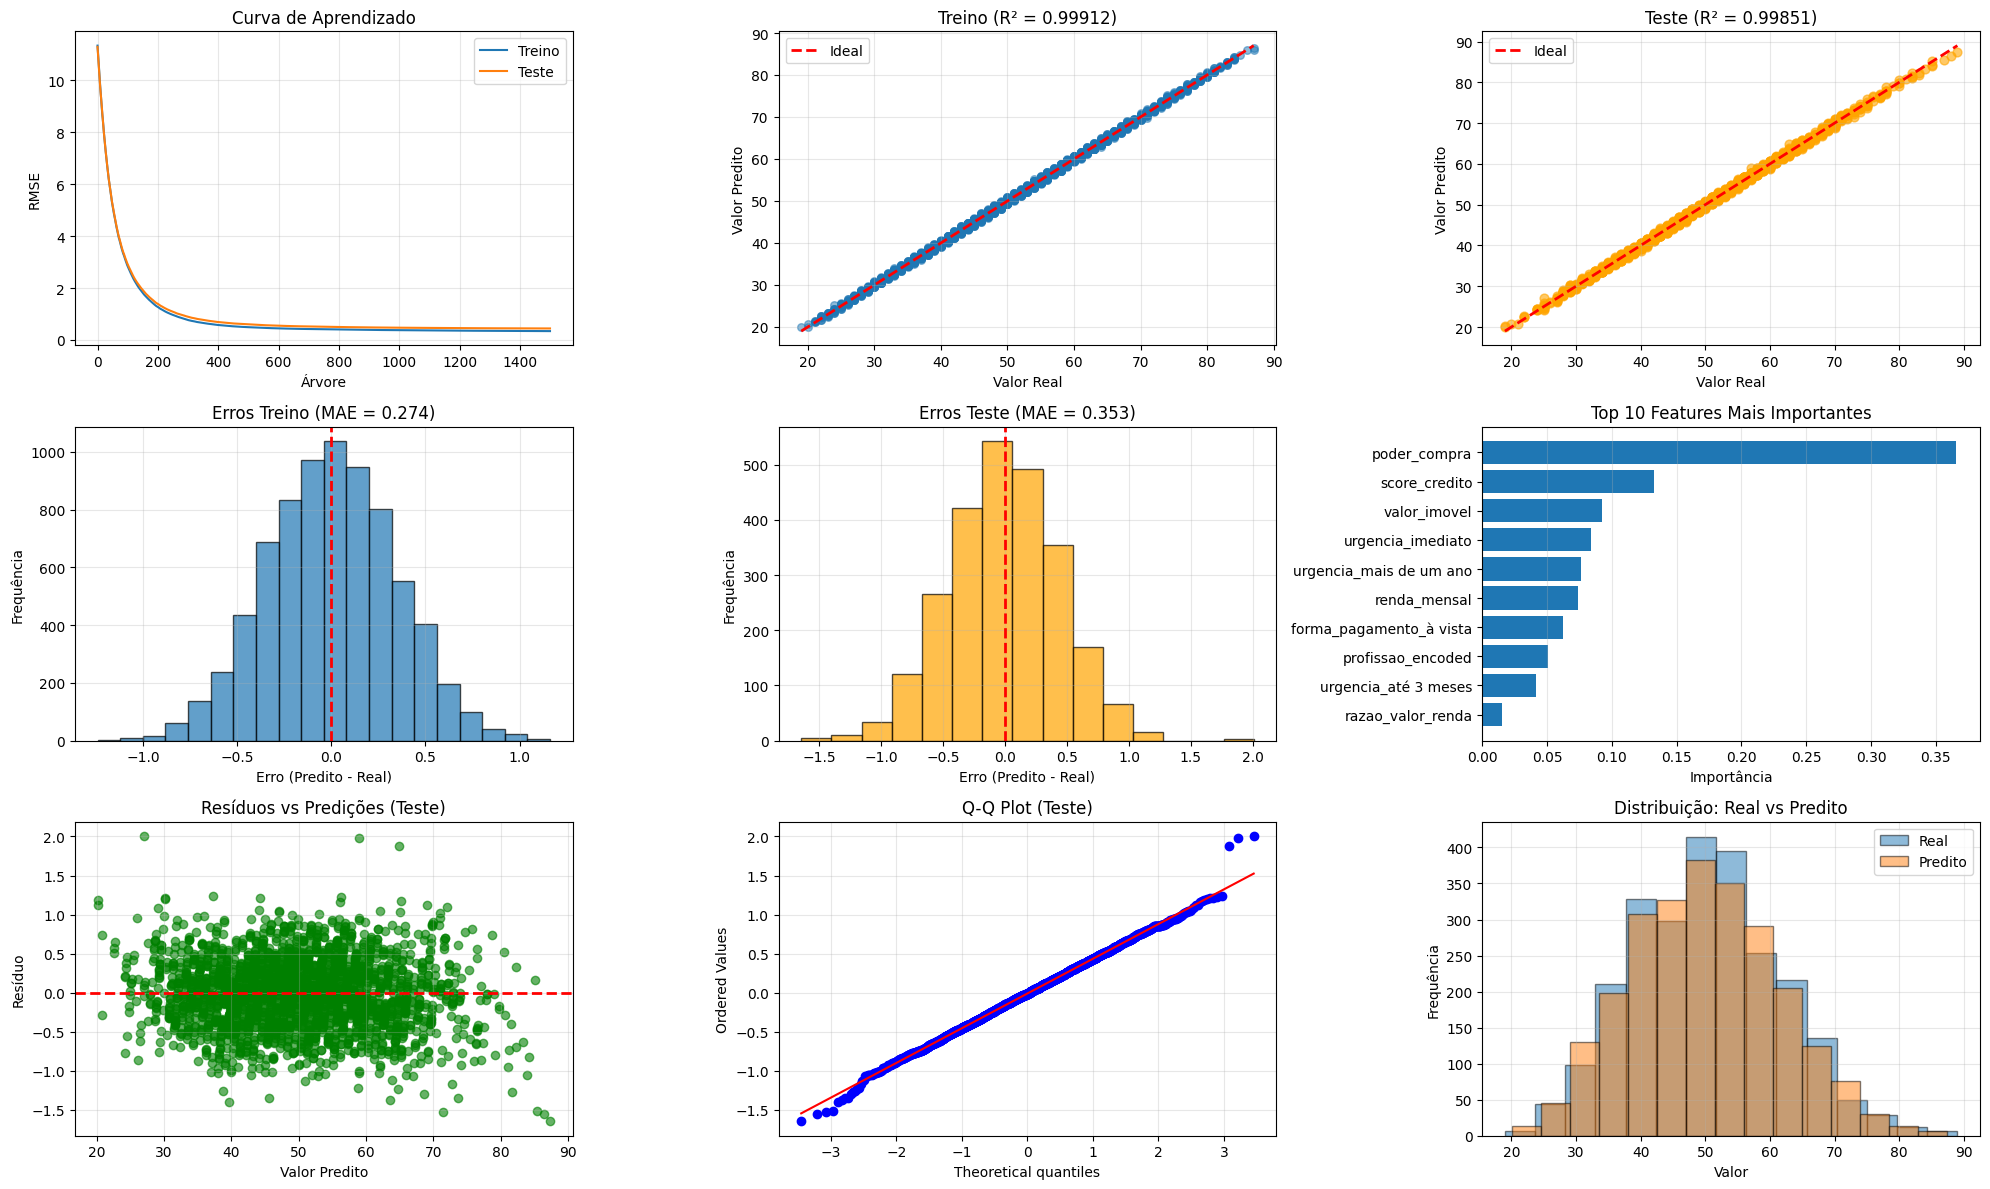

In [12]:
from scipy import stats

fig = plt.figure(figsize=(20, 12))

# 1. Curva de aprendizado (loss por iteração)
ax1 = plt.subplot(3, 3, 1)
results = modelo.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
ax1.plot(x_axis, results['validation_0']['rmse'], label='Treino')
ax1.plot(x_axis, results['validation_1']['rmse'], label='Teste')
ax1.legend()
ax1.set_xlabel('Árvore')
ax1.set_ylabel('RMSE')
ax1.set_title('Curva de Aprendizado')
ax1.grid(True, alpha=0.3)

# 2. Predições vs Real (Treino)
ax2 = plt.subplot(3, 3, 2)
ax2.scatter(y_train, y_train_pred, alpha=0.5, s=30)
min_val_train = min(y_train.min(), y_train_pred.min())
max_val_train = max(y_train.max(), y_train_pred.max())
ax2.plot([min_val_train, max_val_train], [min_val_train, max_val_train], 'r--', lw=2, label='Ideal')
ax2.set_xlabel('Valor Real')
ax2.set_ylabel('Valor Predito')
ax2.set_title(f'Treino (R² = {train_r2:.5f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Predições vs Real (Teste)
ax3 = plt.subplot(3, 3, 3)
ax3.scatter(y_test, y_test_pred, alpha=0.6, s=40, color='orange')
min_val_test = min(y_test.min(), y_test_pred.min())
max_val_test = max(y_test.max(), y_test_pred.max())
ax3.plot([min_val_test, max_val_test], [min_val_test, max_val_test], 'r--', lw=2, label='Ideal')
ax3.set_xlabel('Valor Real')
ax3.set_ylabel('Valor Predito')
ax3.set_title(f'Teste (R² = {test_r2:.5f})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribuição dos erros (Treino)
ax4 = plt.subplot(3, 3, 4)
erros_train = y_train_pred - y_train
ax4.hist(erros_train, bins=20, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Erro (Predito - Real)')
ax4.set_ylabel('Frequência')
ax4.set_title(f'Erros Treino (MAE = {train_mae:.3f})')
ax4.grid(True, alpha=0.3)

# 5. Distribuição dos erros (Teste)
ax5 = plt.subplot(3, 3, 5)
erros_test = y_test_pred - y_test
ax5.hist(erros_test, bins=15, edgecolor='black', alpha=0.7, color='orange')
ax5.axvline(x=0, color='r', linestyle='--', lw=2)
ax5.set_xlabel('Erro (Predito - Real)')
ax5.set_ylabel('Frequência')
ax5.set_title(f'Erros Teste (MAE = {test_mae:.3f})')
ax5.grid(True, alpha=0.3)

# 6. Importância das Features (Top 10)
ax6 = plt.subplot(3, 3, 6)
top_features = importance_df.head(10)
ax6.barh(range(len(top_features)), top_features['importance'])
ax6.set_yticks(range(len(top_features)))
ax6.set_yticklabels(top_features['feature'])
ax6.set_xlabel('Importância')
ax6.set_title('Top 10 Features Mais Importantes')
ax6.invert_yaxis()
ax6.grid(True, alpha=0.3, axis='x')

# 7. Resíduos vs Predições (Teste)
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(y_test_pred, erros_test, alpha=0.6, color='green')
ax7.axhline(y=0, color='r', linestyle='--', lw=2)
ax7.set_xlabel('Valor Predito')
ax7.set_ylabel('Resíduo')
ax7.set_title('Resíduos vs Predições (Teste)')
ax7.grid(True, alpha=0.3)

# 8. Q-Q Plot (verificar normalidade dos erros)
ax8 = plt.subplot(3, 3, 8)
stats.probplot(erros_test, dist="norm", plot=ax8)
ax8.set_title('Q-Q Plot (Teste)')
ax8.grid(True, alpha=0.3)

# 9. Distribuição das predições vs target
ax9 = plt.subplot(3, 3, 9)
ax9.hist(y_test, bins=15, alpha=0.5, label='Real', edgecolor='black')
ax9.hist(y_test_pred, bins=15, alpha=0.5, label='Predito', edgecolor='black')
ax9.set_xlabel('Valor')
ax9.set_ylabel('Frequência')
ax9.set_title('Distribuição: Real vs Predito')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgboost_resultados.png', dpi=300, bbox_inches='tight')
plt.show()

#Função de predição

In [13]:
import pandas as pd
import numpy as np


def score_cliente_xgb(
    renda_mensal, score_credito, idade, valor_imovel,
    profissao, genero, estado_civil, cidade_imovel,
    objetivo, cidade_estado_residencia, urgencia, forma_pagamento
):

    novo_cliente = pd.DataFrame({
        'renda_mensal': [renda_mensal],
        'score_credito': [score_credito],
        'idade': [idade],
        'valor_imovel': [valor_imovel],
        'profissao': [profissao],
        'genero': [genero],
        'estado_civil': [estado_civil],
        'cidade_imovel': [cidade_imovel],
        'objetivo': [objetivo],
        'cidade_estado_residencia': [cidade_estado_residencia],
        'urgencia': [urgencia],
        'forma_pagamento': [forma_pagamento]
    })

    for col in colunas_nominais:
        novo_cliente[col] = novo_cliente[col].str.lower().str.strip()

    novo_cliente['poder_compra'] = novo_cliente['score_credito'] * novo_cliente['renda_mensal'] / 1000
    novo_cliente['razao_valor_renda'] = novo_cliente['valor_imovel'] / (novo_cliente['renda_mensal'] + 1)

    novo_cliente['profissao_encoded'] = target_encoder.transform(novo_cliente[['profissao']])

    novo_cliente_encoded = pd.get_dummies(
        novo_cliente.drop('profissao', axis=1),
        columns=colunas_nominais_sem_profissao,
        drop_first=True
    )

    novo_cliente_final = novo_cliente_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    novo_cliente_final[colunas_numericas] = scaler.transform(novo_cliente_final[colunas_numericas])

    predicao_raw = modelo.predict(novo_cliente_final)[0]

    urgencia_limpa = novo_cliente['urgencia'].iloc[0]

    boost = 1.0

    if(urgencia_limpa == 'imediato'):
        boost = 1.3
    elif(urgencia_limpa == 'até 3 meses'):
        boost = 1.15
    elif(urgencia_limpa == 'mais de 1 ano'):
        boost = 1.05

    predicao_ajustada = predicao_raw * boost
    predicao_final = np.clip(predicao_ajustada, 0, 100)

    print(f"Score: {predicao_final:.2f}")
    return predicao_final.astype(int)

In [14]:
score_cliente_xgb(
    renda_mensal=14000,
    score_credito=730,
    idade=29,
    valor_imovel=1000000,
    profissao='engenheiro',
    genero='masculino',
    estado_civil='solteiro(a)',
    cidade_imovel='rio de janeiro/rj',
    objetivo='moradia',
    cidade_estado_residencia='rio de janeiro/rj',
    urgencia='imediato',
    forma_pagamento='financiamento'
)

Score: 65.66


np.int64(65)